<a href="https://colab.research.google.com/github/wkssm18/case_study/blob/main/March_2023_bank_crisis_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
from google.colab import files
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
yf.pdr_override()

In [3]:
# Made function to grab all the necessary stock price data
def data_df(stock_list, start, end):
  df = pd.DataFrame()
  for i in stock_list:
    data = pdr.get_data_yahoo(i, start, end)
    data = data[['Close']]
    data.columns = [i]
    df = pd.concat([df, data], axis = 1)
  return df

### Retrieved all the necessary price informations.
- indexes: includes NASDAQ (^IXIC) and philadelphia index (^SOX)
- banks: includes UBS and Deutsche bank
- constructors: includes Caterpillar, Fluor, and Lennar which are major constructor companies
- rating_agencies: includes Moody's and Standard & Poor

In [4]:
indexes = ['^IXIC', '^SOX']
us_banks = ['SIVBQ', 'FRCB', 'SBNY']
europe_banks = ['UBS', 'DB']
constructors = ['CAT', 'FLR']
rating_agencies = ['MCO', 'SPGI']

stocks = indexes + us_banks + europe_banks + constructors + rating_agencies
start_date = '2023-02-01'
end_date = '2023-08-31'
df = data_df(stocks, start = start_date, end = end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
upload = files.upload()

#### Retrieved 10 year treasury data and added it to the dataframe

In [6]:
dgs = pd.read_csv('10_year_treasury_1980_to_2023.csv', parse_dates = True, index_col = 'DATE')
dgs[dgs['DGS10'] == '.'] = np.nan
dgs.fillna(method = 'ffill', inplace = True)
dgs['DGS10'] = dgs['DGS10'].astype('float64')

In [7]:
df = pd.concat([df, dgs], axis = 1).dropna()

#### Scaled the data using MinMaxScaler to visually compare the data easier

In [8]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
scaled_df.index = df.index

#### Important dates marker
1. 2023-03-19: Credit Suisse succumbs to crisis. UBS rescues credit Suisse on March 20th 2023.
2. 2023-08-01: Fitch downgrades US
3. 2023-03-22, 2023-06-14, 2023-09-20: FOMC dot plot release date
<br>
*Events are displayed in red dotted vertical lines* <br>
*FOMC dot plot release dates are displayed in blue dotted vertical lines*


In [9]:
def date_marker():
  plt.axvline(x = '2023-03-19', linestyle = '--', alpha = 0.5, color = 'r', linewidth = 0.6)
  plt.axvline(x = '2023-08-01', linestyle = '--', alpha = 0.5, color = 'r', linewidth = 0.6)
  plt.axvline(x = '2023-03-22', linestyle = '--', alpha = 0.5, color = 'b', linewidth = 0.6)
  plt.axvline(x = '2023-06-14', linestyle = '--', alpha = 0.5, color = 'b', linewidth = 0.6)
  plt.axvline(x = '2023-09-20', linestyle = '--', alpha = 0.5, color = 'b', linewidth = 0.6)

#### Compared the two bank bata

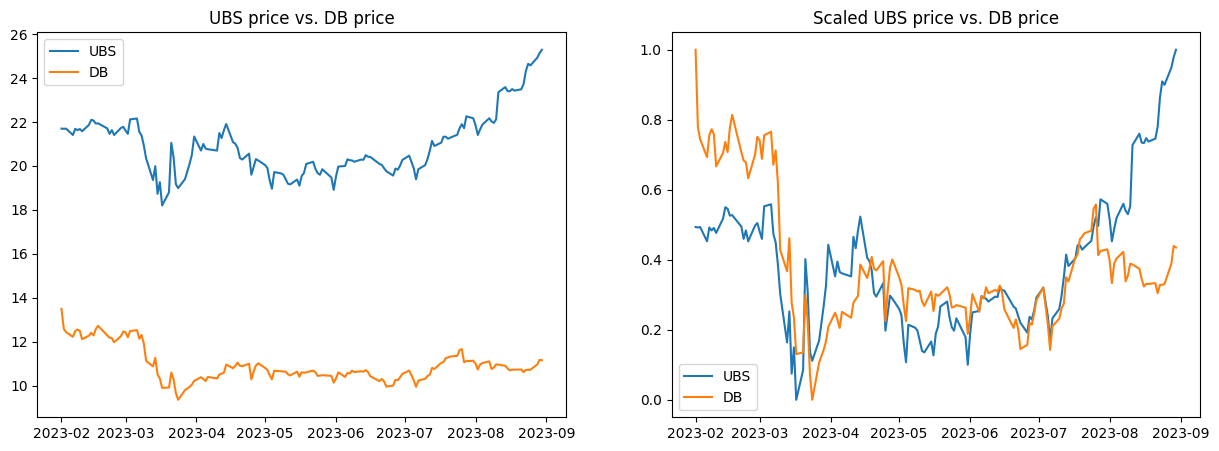

In [10]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(df[['UBS', 'DB']], label = ['UBS', 'DB'])
ax[0].set_title('UBS price vs. DB price')
ax[0].legend()
ax[1].plot(scaled_df[['UBS', 'DB']], label = ['UBS', 'DB'])
ax[1].set_title('Scaled UBS price vs. DB price')
ax[1].legend()
plt.show()

#### Made a heatmap data to see the correlation between different securities

Text(0.5, 1.0, 'Scaled data heatmap')

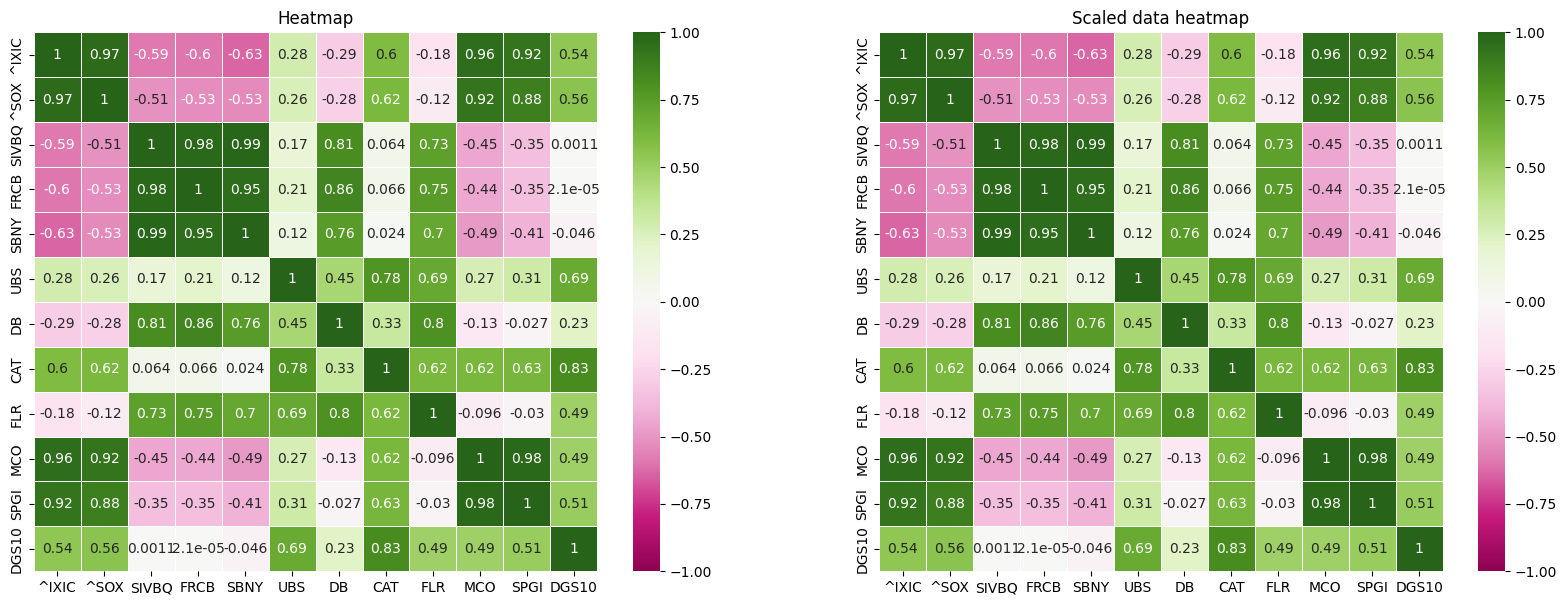

In [11]:
fig, axes = plt.subplots(1,2, figsize = (20,7))
sns.heatmap(data = df.corr(), annot = True, cmap = 'PiYG', linewidth = 0.5, ax = axes[0], vmin = -1, vmax = 1)
sns.heatmap(data = scaled_df.corr(), annot = True, cmap = 'PiYG', linewidth = 0.5, ax = axes[1], vmin = -1, vmax = 1)
axes[0].set_title('Heatmap')
axes[1].set_title('Scaled data heatmap')

Can observe that:
- NASDAQ and Phil index are moving very closely together. Their correlation is also 0.96
- Moody's and Standard & Poor's are moving very closely also. Their correlation is 0.98
- All US banks that got affected during the crisis are closely related. <br>
Therefore, to make it simple, I will combine NASDAQ and Phil index together and Moody's and Standard & Poor's data together and the US banks that got affected during the crisis together

<Axes: >

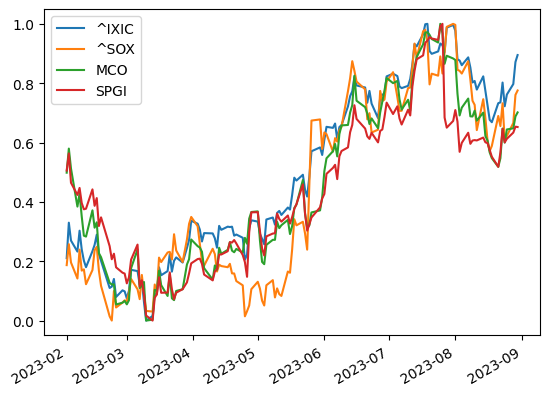

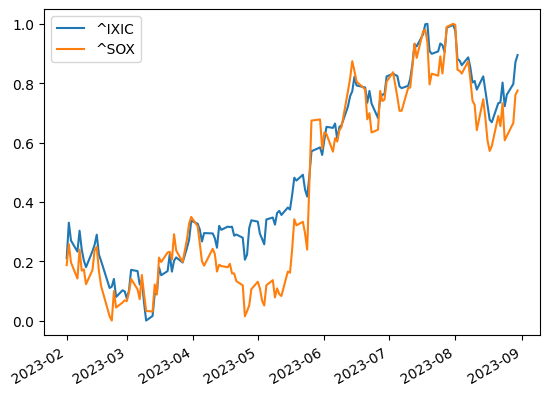

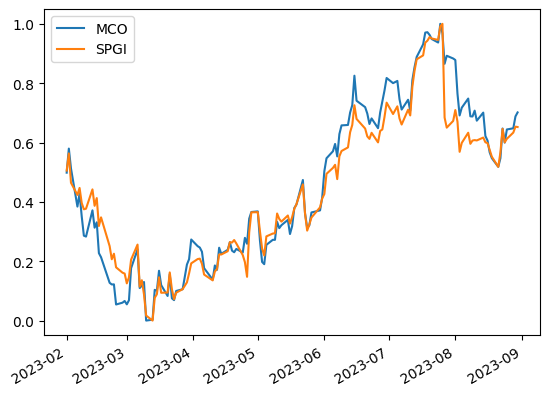

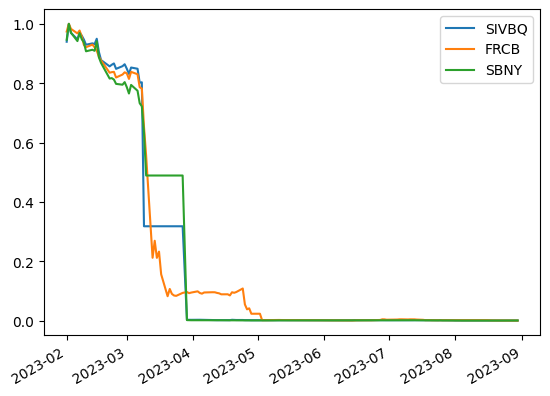

In [12]:
scaled_df[indexes + rating_agencies].plot()
scaled_df[indexes].plot()
scaled_df[rating_agencies].plot()
scaled_df[us_banks].plot()

In [13]:
index_df = pd.DataFrame(scaled_df[indexes].dot([0.5, 0.5]), columns = ['Indexes'])
rating_agencies_df = pd.DataFrame(scaled_df[rating_agencies].dot([0.5, 0.5]), columns = ['Rate_agencies'])
us_banks_df = pd.DataFrame(scaled_df[us_banks].dot([0.3333, 0.3333, 0.3333]), columns = ['US_banks'])
final_scaled_df = pd.concat([index_df, rating_agencies_df, us_banks_df, scaled_df[europe_banks + constructors + ['DGS10']]], axis = 1)

Plot the indexes, rating agencies, and two European banks on the same graph. <br>
- Both indexes and rating agencies are moving very closely together
- Both banks are moving very closely together
- Banks had higher drop, and they recovered slower than the indexes and rating agencies

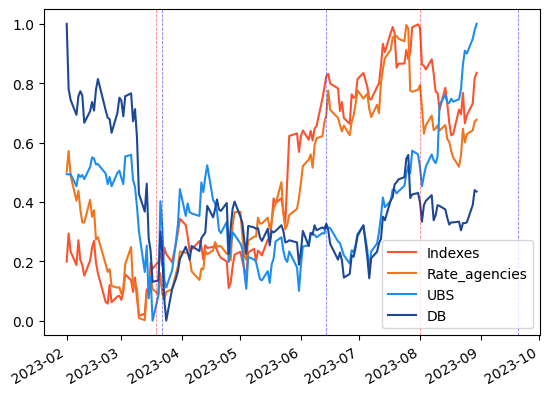

In [14]:
final_scaled_df[['Indexes', 'Rate_agencies', 'UBS', 'DB']].plot(color = ['#fa532d', '#f0751d', '#1d8df0', '#1e4896'])
date_marker()

Plot the indexes, rating agencies, and construction companies on the same graph
- Caterpillar and Fluor had significant drops in March, which continued until around beginning of June.
- Starting from june, both Caterpillar and Fluor had significant increase
- Lennar moved closely together with the indexes and rating agencies

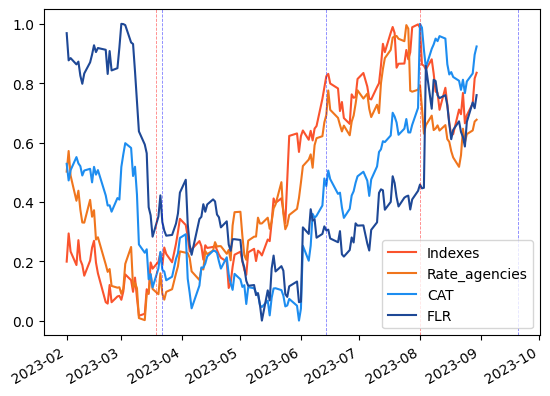

In [15]:
final_scaled_df[['Indexes', 'Rate_agencies', 'CAT', 'FLR']].plot(color = ['#fa532d', '#f0751d', '#1d8df0', '#1e4896'])
date_marker()

Plot the European banks and constructor companies on the same graph
- All of them are moving in a similar fashion
- Correlation heatmap seems to have medium to high correlation between the European bank stocks and construction stocks

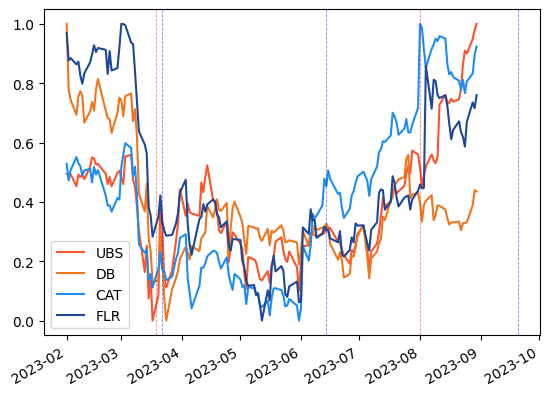

In [16]:
final_scaled_df[europe_banks + constructors].plot(color = ['#fa532d', '#f0751d', '#1d8df0', '#1e4896'])
date_marker()

<Axes: >

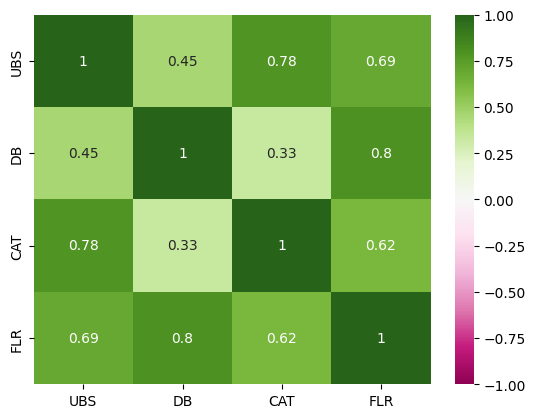

In [17]:
sns.heatmap(final_scaled_df[europe_banks + constructors].corr(), annot = True, cmap = 'PiYG', vmin = -1, vmax = 1)

### Comparison with 10 year treasury

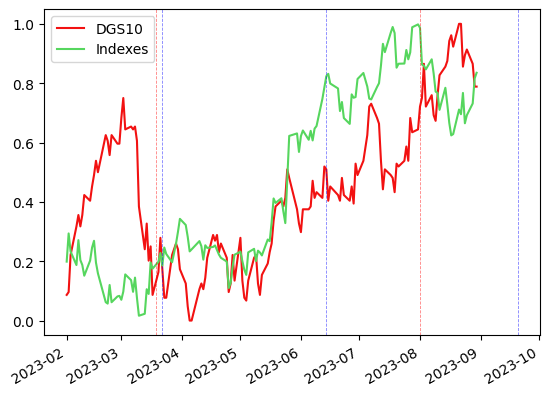

In [18]:
final_scaled_df[['DGS10', 'Indexes']].plot(color = ['#f21111', '#56d65e'])
date_marker()

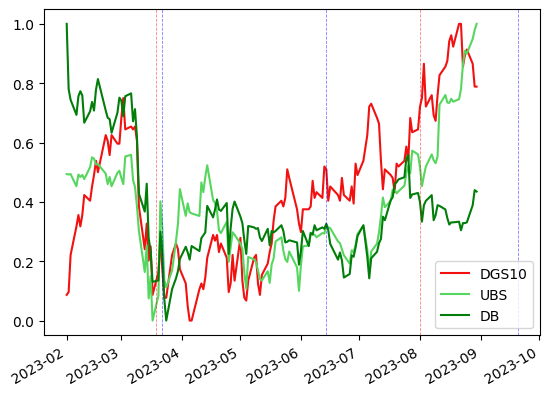

In [19]:
final_scaled_df[['DGS10'] + europe_banks].plot(color = ['#f21111', '#56d65e', '#017d09'])
date_marker()

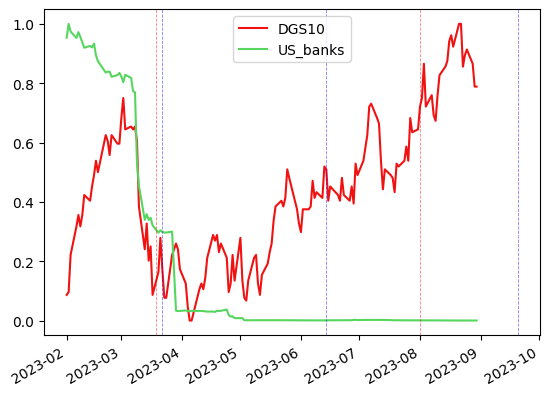

In [20]:
final_scaled_df[['DGS10', 'US_banks']].plot(color = ['#f21111', '#56d65e'])
date_marker()

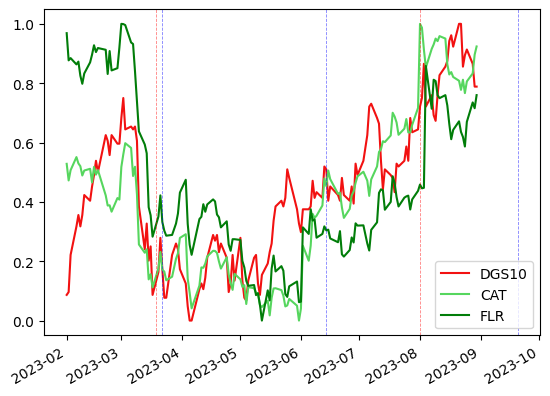

In [21]:
final_scaled_df[['DGS10'] + constructors].plot(color = ['#f21111', '#56d65e', '#017d09'])
date_marker()

### Comparison with European bank stocks

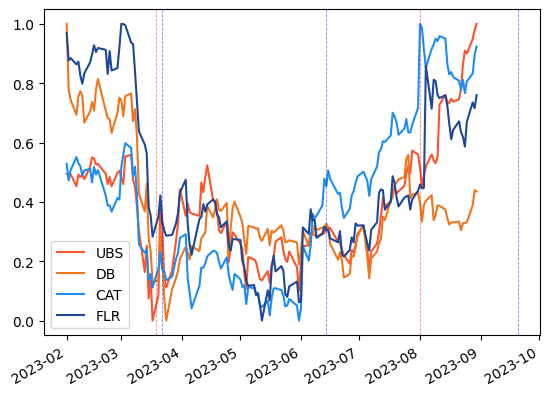

In [22]:
scaled_df[europe_banks + constructors].plot(color = ['#fa532d', '#f0751d', '#1d8df0', '#1e4896'])
date_marker()

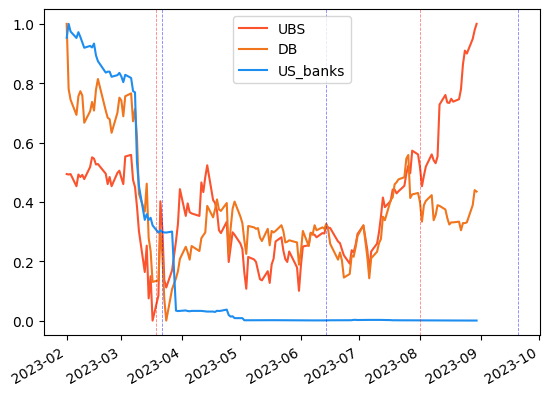

In [23]:
final_scaled_df[europe_banks + ['US_banks']].plot(color = ['#fa532d', '#f0751d', '#1d8df0'])
date_marker()

#### Comparison with indexes (NASDAQ)

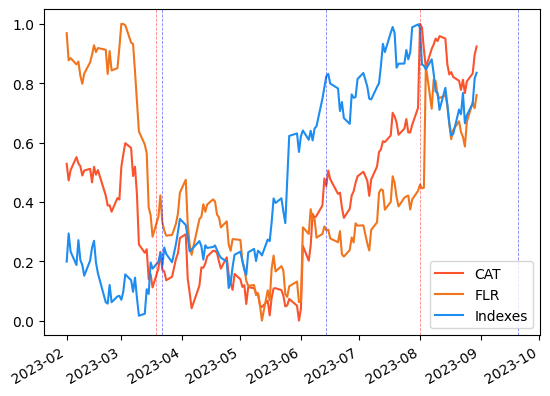

In [24]:
final_scaled_df[constructors + ['Indexes']].plot(color = ['#fa532d', '#f0751d', '#1d8df0'])
date_marker()

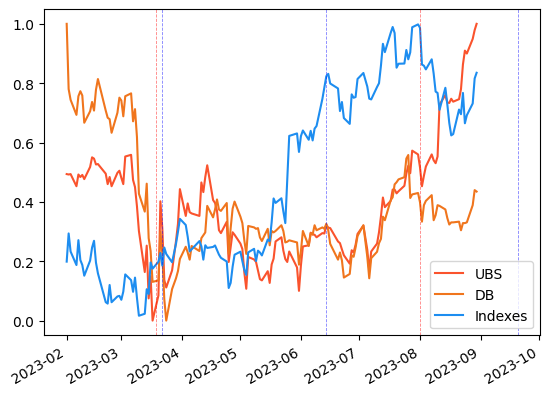

In [25]:
final_scaled_df[europe_banks + ['Indexes']].plot(color = ['#fa532d', '#f0751d', '#1d8df0'])
date_marker()

#### 10 year treasury data from Feb 2023 to today

<Axes: xlabel='DATE'>

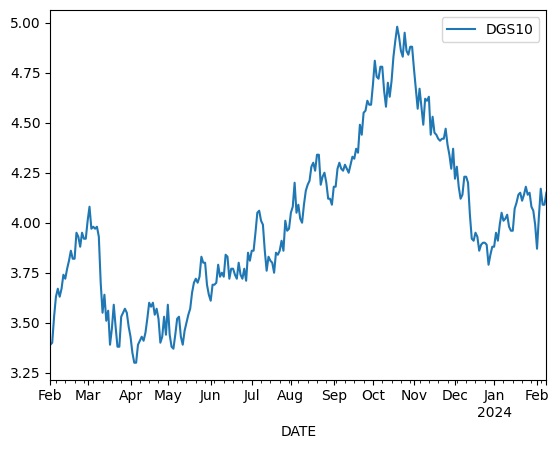

In [26]:
dgs['2023-02-01':].plot()

### Some findings
- There was a peak in 10 year treasury rate before the bank crisis in March 2023
- Both European bank stocks and constructor stocks plunged. Constructor stocks recovered sooner than the European bank stocks
- NASDAQ recovered sooner than both constructor stocks and European stocks
